In [18]:
import csv
import os

import cv2
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from dataManager import DataManager
from maskPredictor import MaskPredictor


def datagen(video_path,nn_weights_path, batch_size=1, output_length=30):
    """Data generator: takes video and weights path and produce a tuple: masks and source """
    data_mngr = DataManager(video_path)
    frame_generator = data_mngr.get_frames_gen(batch_size=batch_size,
                                               num=30*output_length*60)
    nn_model = MaskPredictor(nn_weights_path)
    masks_generator = nn_model.get_mask_generator(frame_generator, th=0.8)

    areas = []

    feature_params = dict(maxCorners=100, qualityLevel=0.3, minDistance=7, blockSize=7)
    # Parameters for Lucas Kanade optical flow
    lk_params = dict(
        winSize=(15, 15),
        maxLevel=2,
        criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03),
    )
    # Create random colors
    color = np.random.randint(0, 255, (100, 3))

    mask, frame, source = next(masks_generator)
 # Create a mask image for drawing purposes
    of_mask = np.zeros_like(frame)
    stored_points = []
    p0 = cv2.goodFeaturesToTrack(mask, mask=None, **feature_params)

    old_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    for i, (mask, frame, source) in tqdm(enumerate(masks_generator)):
        # # contours
        contours = source.copy()
        mask = cv2.resize(mask, (contours.shape[1], contours.shape[0])).astype(np.uint8)
        # mask = cv2.threshold(np.uint8(mask[:,:]*255), 210, 255, cv2.THRESH_BINARY)[1]
        kernel = np.ones((9, 9), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        cnts, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(contours, cnts, -1, (0, 255, 0), 2)

        ## LK Optical flow
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        p1, st, err = cv2.calcOpticalFlowPyrLK(
            old_gray, gray, p0, None, **lk_params
        )
        # Select good points
        good_new = p1[st == 1]
        good_old = p0[st == 1]

        # Draw the tracks
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel()
            c, d = old.ravel()
            of_mask = cv2.line(of_mask, (int(a), int(b)), (int(c), int(d)), color[i].tolist(), 1)
            frame = cv2.circle(frame, (int(a), int(b)), 2, color[i].tolist(), -1)
        # Display the
        # show(frame, mask, cv2.add(frame, mask))
        of = cv2.add(frame, of_mask)

        # Update the previous frame and previous points
        old_gray = gray.copy()
        p0 = good_new.reshape(-1, 1, 2)


        data = {'orig': source,
                'mask': mask,
                'contours':  contours,
                'of':of
                }

        yield data

def visualizer(generator, savepath, output_length=0.5, fps=15, bitrate=1800):
    fig = plt.figure(constrained_layout=True, figsize=(18, 12))
    gs = fig.add_gridspec(4, 4)
    ax_orig = fig.add_subplot(gs[0:2, :2])
    ax_orig.set_title('Исходное изображение', fontsize=12)
    ax_masks = fig.add_subplot(gs[2:, 0:2])
    ax_masks.set_title('Маска', fontsize=12)
    ax_contours = fig.add_subplot(gs[:2, 2:])
    ax_contours.set_title('Рассчитанные контуры', fontsize=12)
    ax_of = fig.add_subplot(gs[2:, 2:])
    ax_of.set_title('Поток', fontsize=12)

    ax_contours.axis('off')
    ax_orig.axis('off')
    ax_masks.axis('off')
    ax_of.axis('off')


    def updateData(data):
        keys = ['orig', 'mask',  'contours', 'of']
        orig, mask,   contours, of = [data[key] for key in keys]
        # original
        ax_orig.clear()
        ax_orig.set_title('Исходное изображение', fontsize=12)
        ax_orig.imshow(orig, aspect='auto')
        ax_orig.axis('off')

        # masks
        ax_masks.clear()
        ax_masks.set_title('Маска', fontsize=12)
        ax_masks.imshow(mask, cmap='gray', aspect='auto')
        ax_masks.axis('off')

        # # contours
        ax_contours.clear()
        ax_contours.set_title('Рассчитанные контуры', fontsize=12)
        ax_contours.imshow(contours, aspect='auto')
        ax_contours.axis('off')

   # # contours
        ax_of.clear()
        ax_of.set_title('Поток', fontsize=12)
        ax_of.imshow(of, aspect='auto')
        ax_of.axis('off')
    simulation = animation.FuncAnimation(fig, updateData, frames=generator, save_count=30*output_length*60)

    writer = animation.writers['ffmpeg'](fps=fps, bitrate=10000)
    simulation.save(savepath, writer=writer)



1it [00:00,  1.14it/s]
2it [00:01,  1.18it/s]
3it [00:02,  1.28it/s]
4it [00:03,  1.35it/s]
5it [00:03,  1.38it/s]
6it [00:04,  1.41it/s]
7it [00:05,  1.42it/s]
8it [00:05,  1.44it/s]
9it [00:06,  1.44it/s]
10it [00:07,  1.44it/s]
11it [00:07,  1.45it/s]
12it [00:08,  1.45it/s]
13it [00:09,  1.45it/s]
14it [00:09,  1.44it/s]
15it [00:10,  1.44it/s]
17it [02:25,  8.54s/it]

17it [00:12,  1.33it/s]

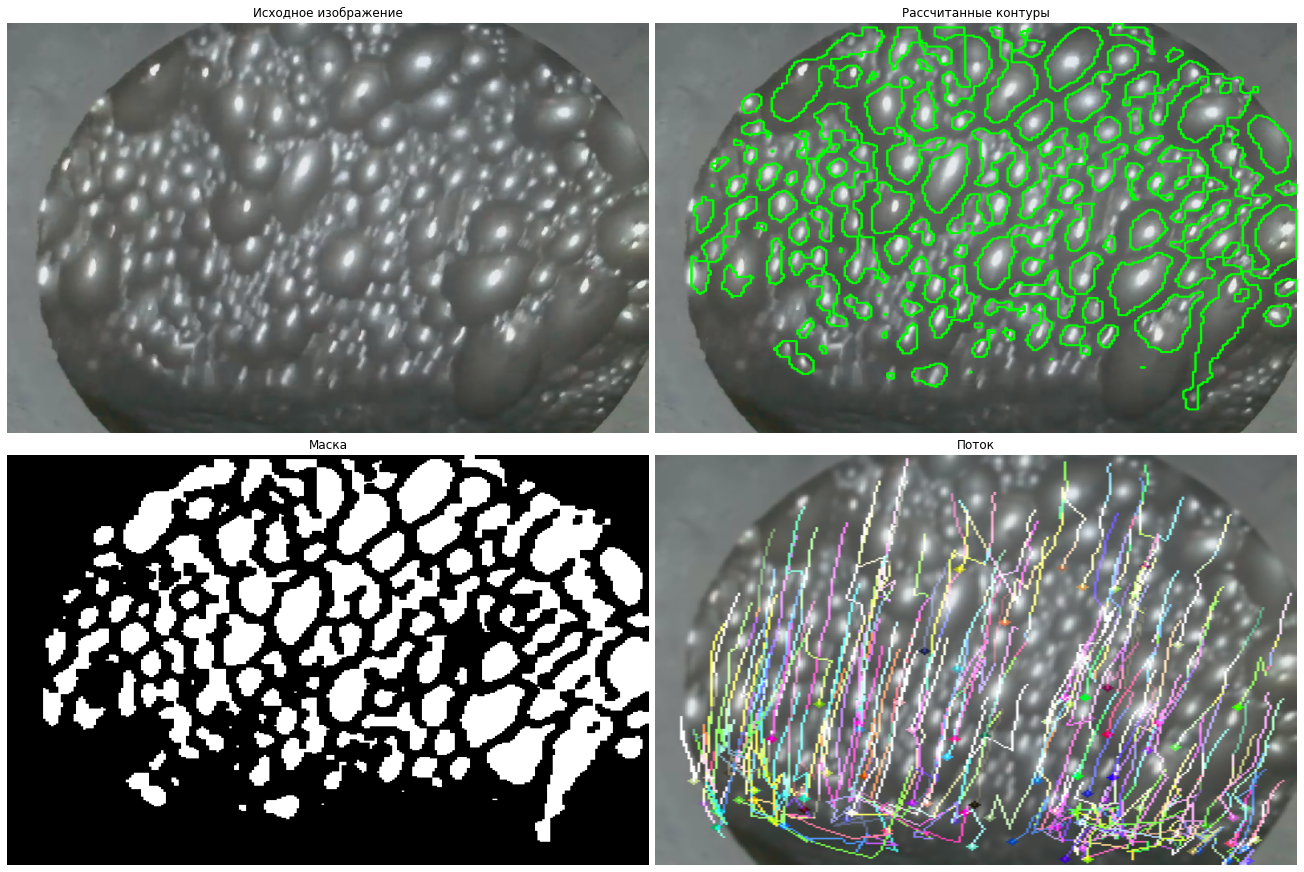

17it [00:11,  1.46it/s]

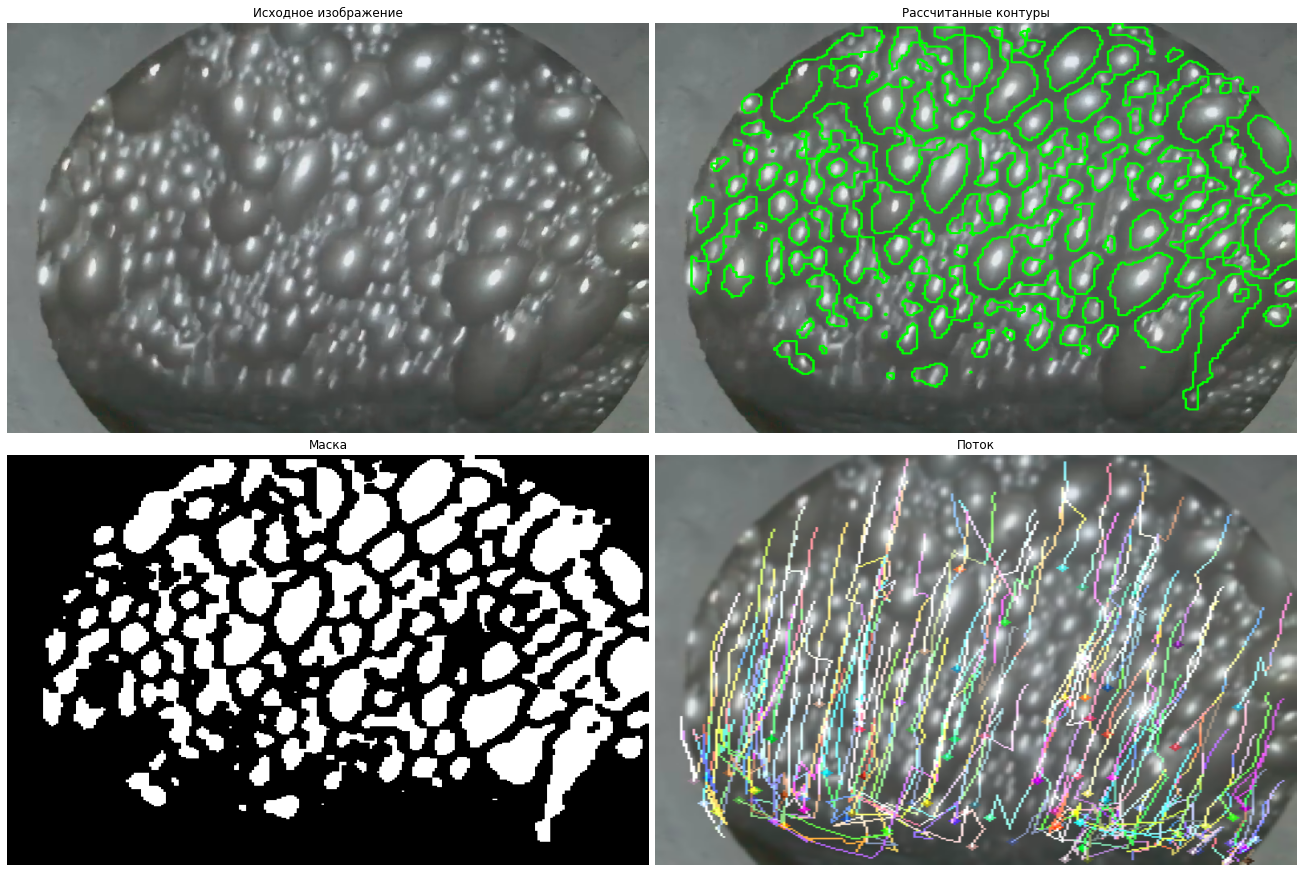

In [19]:
if not os.path.exists('./results'):
    os.makedirs('./results')

if not os.path.exists('./weights'):
    os.makedirs('./weights')

if not os.path.exists('../data'):
    os.makedirs('../data')

generator = datagen('data/90_2_3.mp4', 'weights/unetplusplus_weights.pt', batch_size=1)
visualizer(generator, './results/visualization.mp4', fps=15, output_length=0.01)